In [146]:
import random
random.seed(42)

In [182]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import spacy
from spacy.training import offsets_to_biluo_tags
nlp=spacy.load('en_core_web_lg')

from tqdm import trange
import torch
import torch.nn.functional as F 
from torch.optim import AdamW
from torch.utils.data import TensorDataset,DataLoader,RandomSampler,SequentialSampler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from pytorch_pretrained_bert import BertTokenizer,BertConfig
from transformers import AutoTokenizer, AutoModelForTokenClassification, BertForTokenClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from tqdm import trange, tqdm
import torch
import numpy as np


from seqeval.metrics import classification_report,accuracy_score,f1_score
import warnings
warnings.filterwarnings('ignore')

#Text preprocessing tools
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords,wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
import fitz
import os

#Make each token predict result into softmax mode
from scipy.special import softmax

In [148]:
#Adding '\n' to the default spacy tokenizer
prefixes=[i+'\\n' for i in nlp.Defaults.prefixes]
prefix_regex = spacy.util.compile_prefix_regex(prefixes)
nlp.tokenizer.prefix_search = prefix_regex.search

In [149]:
#Personal custom tags dictionary
entity_dict={
    'Name':'NAME',
    'College Name':'CLG',
    'Degree':'DEG',
    'Graduation Year':'GRADYEAR',
    'Years of Experience': 'YOE',
    'Companies worked at':'COMPANY',
    'Designation':'DESIG',
    'Skills':'SKILLS',
    'Location':'LOC',
    'Email Address':'EMAIL'
}

Load Data

In [150]:
import spacy
from spacy.tokens import DocBin
from tqdm import tqdm  
import json

In [151]:
#Loading the dataset
data_file_address='../dataset/github/Resumes.json'
df=pd.read_json(data_file_address,lines=True)
df=df.drop(['extras'],axis=1)
df.head()

,content,annotation
0,Abhishek Jha\nApplication Development Associat...,"[{'label': ['Skills'], 'points': [{'start': 12..."
1,Afreen Jamadar\nActive member of IIIT Committe...,"[{'label': ['Email Address'], 'points': [{'sta..."
2,"Akhil Yadav Polemaina\nHyderabad, Telangana - ...","[{'label': ['Skills'], 'points': [{'start': 37..."
3,Alok Khandai\nOperational Analyst (SQL DBA) En...,"[{'label': ['Skills'], 'points': [{'start': 80..."
4,Ananya Chavan\nlecturer - oracle tutorials\n\n...,"[{'label': ['Degree'], 'points': [{'start': 20..."


In [152]:
def mergeIntervals(intervals):
    #Sort based on the tuple start (start,end,label)
    sorted_by_lower_bound = sorted(intervals, key=lambda tup: tup[0])
    merged = []

    for higher in sorted_by_lower_bound:
        if not merged:
            merged.append(higher)
        else:
            lower = merged[-1]
            if higher[0] <= lower[1]:
                if lower[2] is higher[2]:
                    upper_bound = max(lower[1], higher[1])
                    merged[-1] = (lower[0], upper_bound, lower[2])
                else:
                    if lower[1] > higher[1]:
                        merged[-1] = lower
                    else:
                        merged[-1] = (lower[0], higher[1], higher[2])
            else:
                merged.append(higher)

    return merged

In [153]:
def get_entities(df):
    
    entities = []
    
    for i in range(len(df)):
        entity = []
    
        for annot in df['annotation'][i]:
            try:
                ent = entity_dict[annot['label'][0]]
                start = annot['points'][0]['start']
                end = annot['points'][0]['end'] + 1
                entity.append((start, end, ent))
            except:
                pass
    
        entity = mergeIntervals(entity)
        entities.append(entity)
    
    return entities

In [154]:
df['entities']=get_entities(df)
df.head()

,content,annotation,entities
0,Abhishek Jha\nApplication Development Associat...,"[{'label': ['Skills'], 'points': [{'start': 12...","[(0, 12, NAME), (13, 46, DESIG), (49, 58, COMP..."
1,Afreen Jamadar\nActive member of IIIT Committe...,"[{'label': ['Email Address'], 'points': [{'sta...","[(0, 14, NAME), (62, 68, LOC), (104, 148, EMAI..."
2,"Akhil Yadav Polemaina\nHyderabad, Telangana - ...","[{'label': ['Skills'], 'points': [{'start': 37...","[(0, 21, NAME), (22, 31, LOC), (65, 117, EMAIL..."
3,Alok Khandai\nOperational Analyst (SQL DBA) En...,"[{'label': ['Skills'], 'points': [{'start': 80...","[(0, 12, NAME), (13, 51, DESIG), (54, 60, COMP..."
4,Ananya Chavan\nlecturer - oracle tutorials\n\n...,"[{'label': ['Degree'], 'points': [{'start': 20...","[(0, 13, NAME), (14, 22, DESIG), (24, 41, COMP..."


In [155]:
df.iloc[0]['entities']

[(0, 12, 'NAME'),
 (13, 46, 'DESIG'),
 (49, 58, 'COMPANY'),
 (60, 69, 'LOC'),
 (95, 146, 'EMAIL'),
 (372, 405, 'DESIG'),
 (407, 416, 'COMPANY'),
 (727, 770, 'DESIG'),
 (771, 814, 'CLG'),
 (856, 861, 'GRADYEAR'),
 (883, 905, 'CLG'),
 (939, 957, 'CLG'),
 (993, 1154, 'SKILLS'),
 (1295, 1622, 'SKILLS')]

In [156]:
def get_train_data(df):
    tags = []
    sentences = []

    for i in range(len(df)):
        text = df['content'][i]
        entities = df['entities'][i]
    
        doc = nlp(text)
    
        tag = offsets_to_biluo_tags(doc, entities)
        tmp = pd.DataFrame([list(doc), tag]).T
        loc = []
        for i in range(len(tmp)):
            if tmp[0][i].text is '.' and tmp[1][i] is 'O':
                loc.append(i)
        loc.append(len(doc))
    
        last = 0
        data = []
        for pos in loc:
            data.append([list(doc)[last:pos], tag[last:pos]])
            last = pos
    
        for d in data:
            tag = ['O' if t is '-' else t for t in d[1]]
            if len(set(tag)) > 1:
                sentences.append(d[0])
                tags.append(tag)
    
    return sentences, tags

In [157]:
sentences, tags = get_train_data(df)
print(len(sentences), len(tags))

779 779


In [158]:
print(sentences[0])
print(tags[0])

[Abhishek, Jha, 
, Application, Development, Associate, -, Accenture, 
, 
, Bengaluru, ,, Karnataka, -, Email, me, on, Indeed, :, indeed.com/r/Abhishek-Jha/10e7a8cb732bc43a, 
, 
, •, To, work, for, an, organization, which, provides, me, the, opportunity, to, improve, my, skills, 
, and, knowledge, for, my, individual, and, company, 's, growth, in, best, possible, ways]
['B-NAME', 'L-NAME', 'O', 'B-DESIG', 'I-DESIG', 'L-DESIG', 'O', 'U-COMPANY', 'O', 'O', 'U-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'B-EMAIL', 'I-EMAIL', 'I-EMAIL', 'L-EMAIL', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [159]:
tag_vals = set(['X', '[CLS]', '[SEP]'])
for i in range(len(tags)):
    tag_vals = tag_vals.union(tags[i])

#tag2idx convert tag to idx, is a dict contains (tag,idx)
tag2idx={t:i for i,t in enumerate(tag_vals)}

#idx2tag convert tag to idx, is a dict contains (idx,tag)
idx2tag = {tag2idx[key] : key for key in tag2idx.keys()}

In [160]:
print(tag_vals)
print(tag2idx)
print(idx2tag)

{'L-CLG', 'L-SKILLS', 'I-GRADYEAR', 'I-DESIG', 'U-SKILLS', 'U-GRADYEAR', 'U-YOE', 'O', '[SEP]', '[CLS]', 'I-CLG', 'U-LOC', 'I-DEG', 'I-EMAIL', 'L-GRADYEAR', 'L-DESIG', 'B-COMPANY', 'B-LOC', 'L-DEG', 'L-YOE', 'L-COMPANY', 'I-COMPANY', 'B-GRADYEAR', 'U-EMAIL', 'I-NAME', 'U-COMPANY', 'B-SKILLS', 'L-EMAIL', 'B-DEG', 'X', 'U-DESIG', 'B-NAME', 'I-LOC', 'B-DESIG', 'U-DEG', 'I-SKILLS', 'B-YOE', 'L-NAME', 'B-EMAIL', 'U-CLG', 'L-LOC', 'B-CLG', 'I-YOE'}
{'L-CLG': 0, 'L-SKILLS': 1, 'I-GRADYEAR': 2, 'I-DESIG': 3, 'U-SKILLS': 4, 'U-GRADYEAR': 5, 'U-YOE': 6, 'O': 7, '[SEP]': 8, '[CLS]': 9, 'I-CLG': 10, 'U-LOC': 11, 'I-DEG': 12, 'I-EMAIL': 13, 'L-GRADYEAR': 14, 'L-DESIG': 15, 'B-COMPANY': 16, 'B-LOC': 17, 'L-DEG': 18, 'L-YOE': 19, 'L-COMPANY': 20, 'I-COMPANY': 21, 'B-GRADYEAR': 22, 'U-EMAIL': 23, 'I-NAME': 24, 'U-COMPANY': 25, 'B-SKILLS': 26, 'L-EMAIL': 27, 'B-DEG': 28, 'X': 29, 'U-DESIG': 30, 'B-NAME': 31, 'I-LOC': 32, 'B-DESIG': 33, 'U-DEG': 34, 'I-SKILLS': 35, 'B-YOE': 36, 'L-NAME': 37, 'B-EMAIL': 

Training Data

In [161]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_gpu=torch.cuda.device_count()
n_gpu

1

In [162]:
#BERT pre-trained tokenizer
tokenizer = AutoTokenizer.from_pretrained('dslim/bert-base-NER', do_lower_case=True)

Tokenizer Text

In [163]:
def get_tokenized_train_data(sentences, tags):

    tokenized_texts = []
    word_piece_labels = []

    for word_list, label in zip(sentences, tags):
    
        # Add [CLS] at the front
        temp_lable = ['[CLS]']
        temp_token = ['[CLS]']
    
        for word, lab in zip(word_list, label):
            token_list = tokenizer.tokenize(word.text)
            for m, token in enumerate(token_list):
                temp_token.append(token)
                if m == 0:
                    temp_lable.append(lab)
                else:
                    temp_lable.append('X')  
                
        # Add [SEP] at the end
        temp_lable.append('[SEP]')
        temp_token.append('[SEP]')
    
        tokenized_texts.append(temp_token)
        word_piece_labels.append(temp_lable)
    
    return tokenized_texts, word_piece_labels

In [164]:
tokenized_texts, word_piece_labels = get_tokenized_train_data(sentences, tags)

In [165]:
#Vector representations of the corresponding words from the input
print(tokenized_texts[0])
print(word_piece_labels[0])

['[CLS]', 'a', '##b', '##his', '##he', '##k', 'j', '##ha', 'application', 'development', 'associate', '-', 'accent', '##ure', 'ben', '##gal', '##uru', ',', 'ka', '##rna', '##ta', '##ka', '-', 'email', 'me', 'on', 'indeed', ':', 'indeed', '.', 'com', '/', 'r', '/', 'a', '##b', '##his', '##he', '##k', '-', 'j', '##ha', '/', '10', '##e', '##7', '##a', '##8', '##c', '##b', '##7', '##32', '##b', '##c', '##43', '##a', '•', 'to', 'work', 'for', 'an', 'organization', 'which', 'provides', 'me', 'the', 'opportunity', 'to', 'improve', 'my', 'skills', 'and', 'knowledge', 'for', 'my', 'individual', 'and', 'company', "'", 's', 'growth', 'in', 'best', 'possible', 'ways', '[SEP]']
['[CLS]', 'B-NAME', 'X', 'X', 'X', 'X', 'L-NAME', 'X', 'B-DESIG', 'I-DESIG', 'L-DESIG', 'O', 'U-COMPANY', 'X', 'U-LOC', 'X', 'X', 'O', 'O', 'X', 'X', 'X', 'O', 'O', 'O', 'O', 'B-EMAIL', 'I-EMAIL', 'I-EMAIL', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X'

Token Embedding

In [166]:
MAX_LEN = 512
bs = 4

#Make text tokens into ids
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
print(len(input_ids[0]))
print(input_ids[0])

512
[  101   170  1830 27516  4638  1377   179  2328  4048  1718  6500   118
  9603  3313 26181  6997 12328   117 24181 11782  1777  1968   118 10632
  1143  1113  5750   131  5750   119  3254   120   187   120   170  1830
 27516  4638  1377   118   179  2328   120  1275  1162  1559  1161  1604
  1665  1830  1559 17101  1830  1665 25631  1161   794  1106  1250  1111
  1126  2369  1134  2790  1143  1103  3767  1106  4607  1139  4196  1105
  3044  1111  1139  2510  1105  1419   112   188  3213  1107  1436  1936
  3242   102     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     

In [167]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in word_piece_labels], maxlen=MAX_LEN, value=tag2idx["O"], 
                     padding="post", dtype="long", truncating="post")
print(len(tags[0]))
print(tags[0])

512
[ 9 31 29 29 29 29 37 29 33  3 15  7 25 29 11 29 29  7  7 29 29 29  7  7
  7  7 38 13 13 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29
 29 29 29 29 29 29 29 29  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7 29  7  7  7  7  7  8  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  

Mask Word Embeeding

In [168]:
attention_masks=[[float(i>0) for i in ii] for ii in input_ids]
print(attention_masks[0])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

Split Data Train and Validation

In [169]:
tr_inputs,val_inputs,tr_tags,val_tags,tr_masks,val_masks=train_test_split(input_ids,tags,attention_masks, random_state=2000, test_size=0.3)

In [170]:
len(tr_inputs),len(val_inputs),len(tr_tags),len(val_tags),len(tr_masks),len(val_masks)

(545, 234, 545, 234, 545, 234)

In [171]:
tr_inputs=torch.tensor(tr_inputs)
val_inputs=torch.tensor(val_inputs)
tr_tags=torch.tensor(tr_tags)
val_tags=torch.tensor(val_tags)
tr_masks=torch.tensor(tr_masks)
val_masks=torch.tensor(val_masks)           

In [172]:
train_data=TensorDataset(tr_inputs,tr_masks,tr_tags)
train_sampler=RandomSampler(train_data) 
train_dataloader=DataLoader(train_data,sampler=train_sampler,batch_size=bs) 

valid_data=TensorDataset(val_inputs,val_masks,val_tags)
valid_sampler=SequentialSampler(valid_data)
valid_dataloader=DataLoader(valid_data,sampler=valid_sampler,batch_size=bs)

In [173]:
bert_model = BertForTokenClassification.from_pretrained('dslim/bert-base-NER',
        num_labels=len(tag2idx),
        id2label=idx2tag,
        label2id=tag2idx,
        ignore_mismatched_sizes = True
    )

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at dslim/bert-base-NER and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([9]) in the checkpoint and torch.Size([43]) in the model instantiated
- classifier.weight: found shape torch.Size([9, 768])

In [174]:
bert_model.to(device)

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [175]:
# Set training parameters
epochs = 100
max_grad_norm = 1.0

# Prepare optimizer
optimizer = AdamW(bert_model.parameters(), lr=3e-5)

# Lists to store losses for visualization
train_losses = []
val_losses = []

# Training loop
for epoch in trange(epochs, desc='Epoch'):
    # Training
    bert_model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    
    for step, batch in enumerate(tqdm(train_dataloader, desc="Training")):
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        # Clear previous gradients
        bert_model.zero_grad()
        
        # Forward pass
        outputs = bert_model(
            input_ids=b_input_ids,
            attention_mask=b_input_mask,
            labels=b_labels
        )
        
        loss = outputs.loss
        
        # Backward pass
        loss.backward()
        
        # Track train loss
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(parameters=bert_model.parameters(), max_norm=max_grad_norm)
        
        # Update parameters
        optimizer.step()
    
    # Calculate average training loss for this epoch
    epoch_train_loss = tr_loss / nb_tr_steps
    train_losses.append(epoch_train_loss)
    
    # Calculate validation loss after each epoch
    bert_model.eval()
    val_loss = 0
    nb_val_steps = 0
    
    with torch.no_grad():
        for batch in tqdm(valid_dataloader, desc="Validation"):
            batch = tuple(t.to(device) for t in batch)
            val_input_ids, val_input_mask, val_labels = batch
            
            outputs = bert_model(
                input_ids=val_input_ids,
                attention_mask=val_input_mask,
                labels=val_labels
            )
            
            tmp_val_loss = outputs.loss
            val_loss += tmp_val_loss.item()
            nb_val_steps += 1
    
    # Calculate average validation loss for this epoch
    epoch_val_loss = val_loss / nb_val_steps
    val_losses.append(epoch_val_loss)
    
    # Print train and validation loss per epoch
    print(f'Epoch {epoch+1}/{epochs}')
    print(f'Training loss: {epoch_train_loss:.4f}')
    print(f'Validation loss: {epoch_val_loss:.4f}')

Epoch:   1%|          | 1/100 [00:44<1:13:32, 44.57s/it]

Epoch 1/100
Training loss: 0.3143
Validation loss: 0.0963


Epoch:   2%|▏         | 2/100 [01:28<1:11:56, 44.05s/it]

Epoch 2/100
Training loss: 0.1068
Validation loss: 0.0826


Epoch:   3%|▎         | 3/100 [02:11<1:10:47, 43.78s/it]

Epoch 3/100
Training loss: 0.0734
Validation loss: 0.0683


Epoch:   4%|▍         | 4/100 [02:55<1:10:09, 43.85s/it]

Epoch 4/100
Training loss: 0.0527
Validation loss: 0.0768


Epoch:   5%|▌         | 5/100 [03:39<1:09:35, 43.96s/it]

Epoch 5/100
Training loss: 0.0428
Validation loss: 0.0660


Epoch:   6%|▌         | 6/100 [04:24<1:09:15, 44.21s/it]

Epoch 6/100
Training loss: 0.0341
Validation loss: 0.0742


Epoch:   7%|▋         | 7/100 [05:07<1:07:59, 43.87s/it]

Epoch 7/100
Training loss: 0.0261
Validation loss: 0.0836


Epoch:   8%|▊         | 8/100 [05:52<1:07:57, 44.32s/it]

Epoch 8/100
Training loss: 0.0218
Validation loss: 0.0958


Epoch:   9%|▉         | 9/100 [06:37<1:07:11, 44.31s/it]

Epoch 9/100
Training loss: 0.0176
Validation loss: 0.1043


Epoch:  10%|█         | 10/100 [07:23<1:07:08, 44.76s/it]

Epoch 10/100
Training loss: 0.0148
Validation loss: 0.0972


Epoch:  11%|█         | 11/100 [08:05<1:05:32, 44.19s/it]

Epoch 11/100
Training loss: 0.0125
Validation loss: 0.1070


Epoch:  12%|█▏        | 12/100 [08:49<1:04:36, 44.05s/it]

Epoch 12/100
Training loss: 0.0106
Validation loss: 0.1096


Epoch:  13%|█▎        | 13/100 [09:32<1:03:25, 43.74s/it]

Epoch 13/100
Training loss: 0.0094
Validation loss: 0.1123


Epoch:  14%|█▍        | 14/100 [10:16<1:02:43, 43.77s/it]

Epoch 14/100
Training loss: 0.0082
Validation loss: 0.1158


Epoch:  15%|█▌        | 15/100 [10:59<1:01:48, 43.63s/it]

Epoch 15/100
Training loss: 0.0078
Validation loss: 0.1175


Epoch:  16%|█▌        | 16/100 [11:44<1:01:38, 44.03s/it]

Epoch 16/100
Training loss: 0.0075
Validation loss: 0.1204


Epoch:  17%|█▋        | 17/100 [12:28<1:00:54, 44.02s/it]

Epoch 17/100
Training loss: 0.0077
Validation loss: 0.1181


Epoch:  18%|█▊        | 18/100 [13:12<1:00:11, 44.04s/it]

Epoch 18/100
Training loss: 0.0070
Validation loss: 0.1220


Epoch:  19%|█▉        | 19/100 [13:55<59:03, 43.75s/it]  

Epoch 19/100
Training loss: 0.0064
Validation loss: 0.1258


Epoch:  20%|██        | 20/100 [14:39<58:16, 43.71s/it]

Epoch 20/100
Training loss: 0.0058
Validation loss: 0.1351


Epoch:  21%|██        | 21/100 [15:24<58:08, 44.15s/it]

Epoch 21/100
Training loss: 0.0062
Validation loss: 0.1257


Epoch:  22%|██▏       | 22/100 [16:10<57:55, 44.56s/it]

Epoch 22/100
Training loss: 0.0059
Validation loss: 0.1198


Epoch:  23%|██▎       | 23/100 [16:53<56:49, 44.28s/it]

Epoch 23/100
Training loss: 0.0057
Validation loss: 0.1234


Epoch:  24%|██▍       | 24/100 [17:36<55:37, 43.91s/it]

Epoch 24/100
Training loss: 0.0051
Validation loss: 0.1256


Epoch:  25%|██▌       | 25/100 [18:20<54:42, 43.77s/it]

Epoch 25/100
Training loss: 0.0058
Validation loss: 0.1229


Epoch:  26%|██▌       | 26/100 [19:05<54:29, 44.18s/it]

Epoch 26/100
Training loss: 0.0050
Validation loss: 0.1287


Epoch:  27%|██▋       | 27/100 [19:51<54:14, 44.58s/it]

Epoch 27/100
Training loss: 0.0046
Validation loss: 0.1345


Epoch:  28%|██▊       | 28/100 [20:36<53:54, 44.92s/it]

Epoch 28/100
Training loss: 0.0050
Validation loss: 0.1307


Epoch:  29%|██▉       | 29/100 [21:22<53:23, 45.13s/it]

Epoch 29/100
Training loss: 0.0050
Validation loss: 0.1294


Epoch:  30%|███       | 30/100 [22:08<52:58, 45.41s/it]

Epoch 30/100
Training loss: 0.0049
Validation loss: 0.1399


Epoch:  31%|███       | 31/100 [22:52<51:51, 45.10s/it]

Epoch 31/100
Training loss: 0.0042
Validation loss: 0.1439


Epoch:  32%|███▏      | 32/100 [23:38<51:23, 45.35s/it]

Epoch 32/100
Training loss: 0.0049
Validation loss: 0.1270


Epoch:  33%|███▎      | 33/100 [24:23<50:22, 45.11s/it]

Epoch 33/100
Training loss: 0.0042
Validation loss: 0.1328


Epoch:  34%|███▍      | 34/100 [25:08<49:45, 45.23s/it]

Epoch 34/100
Training loss: 0.0041
Validation loss: 0.1310


Epoch:  35%|███▌      | 35/100 [25:52<48:32, 44.81s/it]

Epoch 35/100
Training loss: 0.0038
Validation loss: 0.1406


Epoch:  36%|███▌      | 36/100 [26:36<47:25, 44.46s/it]

Epoch 36/100
Training loss: 0.0037
Validation loss: 0.1325


Epoch:  37%|███▋      | 37/100 [27:22<47:11, 44.94s/it]

Epoch 37/100
Training loss: 0.0053
Validation loss: 0.1345


Epoch:  38%|███▊      | 38/100 [28:10<47:34, 46.05s/it]

Epoch 38/100
Training loss: 0.0064
Validation loss: 0.1251


Epoch:  39%|███▉      | 39/100 [28:59<47:34, 46.80s/it]

Epoch 39/100
Training loss: 0.0048
Validation loss: 0.1421


Epoch:  40%|████      | 40/100 [29:47<47:16, 47.28s/it]

Epoch 40/100
Training loss: 0.0055
Validation loss: 0.1824


Epoch:  41%|████      | 41/100 [30:35<46:27, 47.24s/it]

Epoch 41/100
Training loss: 0.0043
Validation loss: 0.1408


Epoch:  42%|████▏     | 42/100 [31:17<44:18, 45.83s/it]

Epoch 42/100
Training loss: 0.0039
Validation loss: 0.1422


Epoch:  43%|████▎     | 43/100 [32:00<42:34, 44.81s/it]

Epoch 43/100
Training loss: 0.0034
Validation loss: 0.1429


Epoch:  44%|████▍     | 44/100 [32:42<41:10, 44.11s/it]

Epoch 44/100
Training loss: 0.0033
Validation loss: 0.1473


Epoch:  45%|████▌     | 45/100 [33:25<40:00, 43.64s/it]

Epoch 45/100
Training loss: 0.0036
Validation loss: 0.1467


Epoch:  46%|████▌     | 46/100 [34:07<38:55, 43.26s/it]

Epoch 46/100
Training loss: 0.0037
Validation loss: 0.1387


Epoch:  47%|████▋     | 47/100 [34:49<37:56, 42.96s/it]

Epoch 47/100
Training loss: 0.0041
Validation loss: 0.1363


Epoch:  48%|████▊     | 48/100 [35:32<37:04, 42.78s/it]

Epoch 48/100
Training loss: 0.0036
Validation loss: 0.1380


Epoch:  49%|████▉     | 49/100 [36:14<36:24, 42.83s/it]

Epoch 49/100
Training loss: 0.0041
Validation loss: 0.1407


Epoch:  50%|█████     | 50/100 [36:57<35:34, 42.69s/it]

Epoch 50/100
Training loss: 0.0041
Validation loss: 0.1427


Epoch:  51%|█████     | 51/100 [37:39<34:45, 42.56s/it]

Epoch 51/100
Training loss: 0.0037
Validation loss: 0.1446


Epoch:  52%|█████▏    | 52/100 [38:22<34:00, 42.51s/it]

Epoch 52/100
Training loss: 0.0039
Validation loss: 0.1364


Epoch:  53%|█████▎    | 53/100 [39:04<33:14, 42.44s/it]

Epoch 53/100
Training loss: 0.0037
Validation loss: 0.1417


Epoch:  54%|█████▍    | 54/100 [39:46<32:28, 42.36s/it]

Epoch 54/100
Training loss: 0.0049
Validation loss: 0.1378


Epoch:  55%|█████▌    | 55/100 [40:28<31:46, 42.36s/it]

Epoch 55/100
Training loss: 0.0039
Validation loss: 0.1381


Epoch:  56%|█████▌    | 56/100 [41:11<31:02, 42.32s/it]

Epoch 56/100
Training loss: 0.0036
Validation loss: 0.1470


Epoch:  57%|█████▋    | 57/100 [41:53<30:26, 42.48s/it]

Epoch 57/100
Training loss: 0.0035
Validation loss: 0.1440


Epoch:  58%|█████▊    | 58/100 [42:36<29:41, 42.43s/it]

Epoch 58/100
Training loss: 0.0035
Validation loss: 0.1545


Epoch:  59%|█████▉    | 59/100 [43:18<28:56, 42.34s/it]

Epoch 59/100
Training loss: 0.0036
Validation loss: 0.1480


Epoch:  60%|██████    | 60/100 [44:00<28:13, 42.35s/it]

Epoch 60/100
Training loss: 0.0034
Validation loss: 0.1433


Epoch:  61%|██████    | 61/100 [44:43<27:31, 42.33s/it]

Epoch 61/100
Training loss: 0.0037
Validation loss: 0.1324


Epoch:  62%|██████▏   | 62/100 [45:25<26:49, 42.35s/it]

Epoch 62/100
Training loss: 0.0036
Validation loss: 0.1299


Epoch:  63%|██████▎   | 63/100 [46:07<26:07, 42.35s/it]

Epoch 63/100
Training loss: 0.0077
Validation loss: 0.1382


Epoch:  64%|██████▍   | 64/100 [46:50<25:24, 42.35s/it]

Epoch 64/100
Training loss: 0.0058
Validation loss: 0.1348


Epoch:  65%|██████▌   | 65/100 [47:32<24:42, 42.35s/it]

Epoch 65/100
Training loss: 0.0056
Validation loss: 0.1235


Epoch:  66%|██████▌   | 66/100 [48:14<24:00, 42.37s/it]

Epoch 66/100
Training loss: 0.0040
Validation loss: 0.1342


Epoch:  67%|██████▋   | 67/100 [48:57<23:22, 42.51s/it]

Epoch 67/100
Training loss: 0.0042
Validation loss: 0.1218


Epoch:  68%|██████▊   | 68/100 [49:40<22:39, 42.47s/it]

Epoch 68/100
Training loss: 0.0033
Validation loss: 0.1366


Epoch:  69%|██████▉   | 69/100 [50:22<22:00, 42.58s/it]

Epoch 69/100
Training loss: 0.0034
Validation loss: 0.1355


Epoch:  70%|███████   | 70/100 [51:05<21:16, 42.56s/it]

Epoch 70/100
Training loss: 0.0035
Validation loss: 0.1506


Epoch:  71%|███████   | 71/100 [51:49<20:43, 42.87s/it]

Epoch 71/100
Training loss: 0.0033
Validation loss: 0.1429


Epoch:  72%|███████▏  | 72/100 [52:31<19:57, 42.76s/it]

Epoch 72/100
Training loss: 0.0033
Validation loss: 0.1415


Epoch:  73%|███████▎  | 73/100 [53:13<19:10, 42.62s/it]

Epoch 73/100
Training loss: 0.0033
Validation loss: 0.1374


Epoch:  74%|███████▍  | 74/100 [53:56<18:29, 42.69s/it]

Epoch 74/100
Training loss: 0.0031
Validation loss: 0.1412


Epoch:  75%|███████▌  | 75/100 [54:39<17:45, 42.63s/it]

Epoch 75/100
Training loss: 0.0031
Validation loss: 0.1396


Epoch:  76%|███████▌  | 76/100 [55:21<17:01, 42.56s/it]

Epoch 76/100
Training loss: 0.0033
Validation loss: 0.1435


Epoch:  77%|███████▋  | 77/100 [56:03<16:16, 42.48s/it]

Epoch 77/100
Training loss: 0.0031
Validation loss: 0.1459


Epoch:  78%|███████▊  | 78/100 [56:45<15:31, 42.33s/it]

Epoch 78/100
Training loss: 0.0032
Validation loss: 0.1509


Epoch:  79%|███████▉  | 79/100 [57:28<14:48, 42.30s/it]

Epoch 79/100
Training loss: 0.0038
Validation loss: 0.1497


Epoch:  80%|████████  | 80/100 [58:10<14:03, 42.20s/it]

Epoch 80/100
Training loss: 0.0039
Validation loss: 0.1392


Epoch:  81%|████████  | 81/100 [58:52<13:22, 42.23s/it]

Epoch 81/100
Training loss: 0.0041
Validation loss: 0.1419


Epoch:  82%|████████▏ | 82/100 [59:34<12:39, 42.20s/it]

Epoch 82/100
Training loss: 0.0039
Validation loss: 0.1328


Epoch:  83%|████████▎ | 83/100 [1:00:16<11:58, 42.26s/it]

Epoch 83/100
Training loss: 0.0037
Validation loss: 0.1593


Epoch:  84%|████████▍ | 84/100 [1:00:59<11:16, 42.26s/it]

Epoch 84/100
Training loss: 0.0035
Validation loss: 0.1439


Epoch:  85%|████████▌ | 85/100 [1:01:41<10:33, 42.25s/it]

Epoch 85/100
Training loss: 0.0038
Validation loss: 0.1432


Epoch:  86%|████████▌ | 86/100 [1:02:23<09:52, 42.29s/it]

Epoch 86/100
Training loss: 0.0059
Validation loss: 0.1474


Epoch:  87%|████████▋ | 87/100 [1:03:05<09:09, 42.27s/it]

Epoch 87/100
Training loss: 0.0045
Validation loss: 0.1439


Epoch:  88%|████████▊ | 88/100 [1:03:48<08:27, 42.26s/it]

Epoch 88/100
Training loss: 0.0036
Validation loss: 0.1385


Epoch:  89%|████████▉ | 89/100 [1:04:31<07:47, 42.49s/it]

Epoch 89/100
Training loss: 0.0034
Validation loss: 0.1372


Epoch:  90%|█████████ | 90/100 [1:05:13<07:04, 42.49s/it]

Epoch 90/100
Training loss: 0.0033
Validation loss: 0.1461


Epoch:  91%|█████████ | 91/100 [1:05:56<06:21, 42.44s/it]

Epoch 91/100
Training loss: 0.0032
Validation loss: 0.1449


Epoch:  92%|█████████▏| 92/100 [1:06:38<05:39, 42.41s/it]

Epoch 92/100
Training loss: 0.0033
Validation loss: 0.1446


Epoch:  93%|█████████▎| 93/100 [1:07:20<04:56, 42.42s/it]

Epoch 93/100
Training loss: 0.0033
Validation loss: 0.1504


Epoch:  94%|█████████▍| 94/100 [1:08:03<04:14, 42.41s/it]

Epoch 94/100
Training loss: 0.0033
Validation loss: 0.1468


Epoch:  95%|█████████▌| 95/100 [1:08:45<03:32, 42.46s/it]

Epoch 95/100
Training loss: 0.0033
Validation loss: 0.1505


Epoch:  96%|█████████▌| 96/100 [1:09:28<02:50, 42.57s/it]

Epoch 96/100
Training loss: 0.0035
Validation loss: 0.1476


Epoch:  97%|█████████▋| 97/100 [1:10:11<02:08, 42.74s/it]

Epoch 97/100
Training loss: 0.0063
Validation loss: 0.1420


Epoch:  98%|█████████▊| 98/100 [1:10:56<01:26, 43.31s/it]

Epoch 98/100
Training loss: 0.0037
Validation loss: 0.1359


Epoch:  99%|█████████▉| 99/100 [1:11:40<00:43, 43.55s/it]

Epoch 99/100
Training loss: 0.0038
Validation loss: 0.1370


Epoch: 100%|██████████| 100/100 [1:12:24<00:00, 43.44s/it]

Epoch 100/100
Training loss: 0.0034
Validation loss: 0.1420


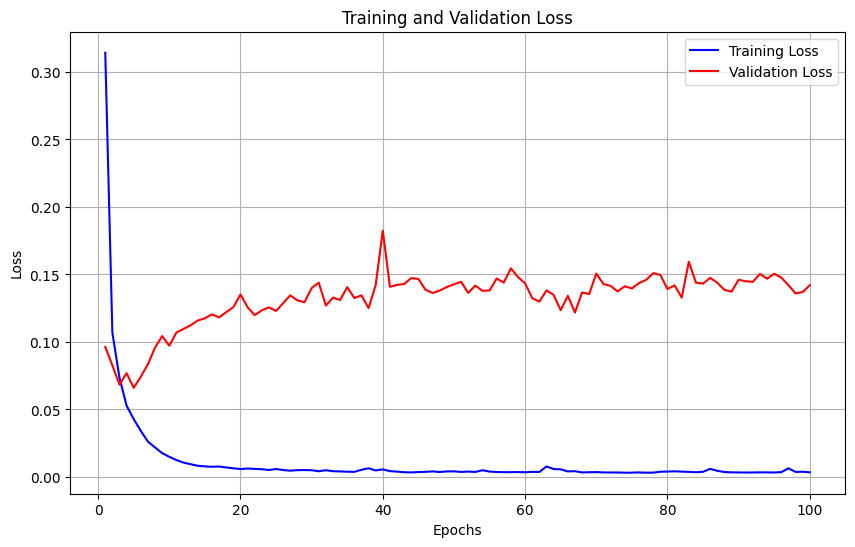

Final Training Loss: 0.0034
Final Validation Loss: 0.1420


In [176]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), train_losses, 'b-', label='Training Loss')
plt.plot(range(1, epochs+1), val_losses, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('../results/bert_training_validation_loss.png')
plt.show()

# Print the final training and validation loss
print(f'Final Training Loss: {train_losses[-1]:.4f}')
print(f'Final Validation Loss: {val_losses[-1]:.4f}')

In [177]:
# Evaluation loop
def evaluate_model(model, dataloader):
    model.eval()
    
    y_true = []
    y_pred = []
    
    eval_loss = 0
    nb_eval_steps = 0
    
    for batch in tqdm(dataloader, desc="Evaluating"):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, label_ids = batch
        
        with torch.no_grad():
            outputs = model(
                input_ids=input_ids, 
                attention_mask=input_mask,
                labels=label_ids
            )
            
            loss = outputs.loss
            logits = outputs.logits
            
        # Track eval loss
        eval_loss += loss.item()
        nb_eval_steps += 1
        
        # Get NER predictions
        logits = logits.detach().cpu().numpy()
        predictions = np.argmax(logits, axis=2)
        
        # Get NER true labels
        label_ids = label_ids.to('cpu').numpy()
        
        # Get attention mask to identify real tokens vs padding
        input_mask = input_mask.to('cpu').numpy()
        
        # Compare only the valuable prediction results
        for i, mask in enumerate(input_mask):
            temp_true = []  # Real labels
            temp_pred = []  # Predicted labels
            
            for j, m in enumerate(mask):
                # Only process tokens that aren't padding (mask=1)
                if m:
                    if idx2tag[label_ids[i][j]] not in ['X', '[CLS]', '[SEP]']:
                        temp_true.append(idx2tag[label_ids[i][j]])
                        temp_pred.append(idx2tag[predictions[i][j]])
                else:
                    # Break when we hit padding
                    break
                    
            y_true.append(temp_true)
            y_pred.append(temp_pred)
    
    # Calculate average loss
    eval_loss = eval_loss / nb_eval_steps
    
    # Calculate metrics
    f1 = f1_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, digits=4)
    
    return eval_loss, f1, accuracy, report

In [183]:
# Run evaluation on the validation set
print("Evaluating model on validation dataset...")
val_loss, val_f1, val_accuracy, val_report = evaluate_model(bert_model, valid_dataloader)

print(f"Validation loss: {val_loss:.4f}")
print(f"F1 score: {val_f1:.4f}")
print(f"Accuracy score: {val_accuracy:.4f}")
print(f"Classification report:\n{val_report}")

Evaluating model on validation dataset...


Evaluating: 100%|██████████| 59/59 [00:04<00:00, 13.04it/s]


Validation loss: 0.1420
F1 score: 0.5328
Accuracy score: 0.8417
Classification report:
              precision    recall  f1-score   support

         CLG     0.3232    0.4923    0.3902        65
     COMPANY     0.5924    0.6770    0.6319       161
         DEG     0.4196    0.7015    0.5251        67
       DESIG     0.5133    0.5923    0.5500       130
       EMAIL     0.4667    0.5833    0.5185        48
    GRADYEAR     0.4304    0.6296    0.5113        54
         LOC     0.6837    0.5929    0.6351       113
        NAME     0.9167    0.9041    0.9103        73
      SKILLS     0.2321    0.3391    0.2756       115
         YOE     0.0000    0.0000    0.0000         9
           _     0.0000    0.0000    0.0000         0

   micro avg     0.4807    0.5976    0.5328       835
   macro avg     0.4162    0.5011    0.4498       835
weighted avg     0.5123    0.5976    0.5463       835



In [184]:
def save_model_to_bin(model, output_dir, model_name="bert_model.bin"):
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Define the path for the model file
    model_path = os.path.join(output_dir, model_name)
    
    # Save the model state dictionary
    print(f"Saving model to {model_path}")
    torch.save(model.state_dict(), model_path)
    print("Model saved successfully!")
    
    # Return the path for reference
    return model_path

In [185]:
output_directory = "results"
model_filename = "bert_ner_model.bin"
saved_model_path = save_model_to_bin(
    model=bert_model,
    output_dir=output_directory,
    model_name=model_filename
)

Saving model to results/bert_ner_model.bin
Model saved successfully!


BERT Preprocessing

In [186]:
# JSON formatting functions
import logging
import re
def convert_dataturks_to_spacy(dataturks_JSON_FilePath):
    try:
        training_data = []
        lines=[]
        with open(dataturks_JSON_FilePath, 'r',encoding='utf-8') as f:
          lines = f.readlines()

        for line in lines:
            data = json.loads(line)
            text = data['content'].replace("\n", " ")
            entities = []
            data_annotations = data['annotation']
            if data_annotations is not None:
                for annotation in data_annotations:
                    #only a single point in text annotation.
                    point = annotation['points'][0]
                    labels = annotation['label']
                    # handle both list of labels or a single label.
                    if not isinstance(labels, list):
                        labels = [labels]

                    for label in labels:
                        point_start = point['start']
                        point_end = point['end']
                        point_text = point['text']
                        
                        lstrip_diff = len(point_text) - len(point_text.lstrip())
                        rstrip_diff = len(point_text) - len(point_text.rstrip())
                        if lstrip_diff != 0:
                            point_start = point_start + lstrip_diff
                        if rstrip_diff != 0:
                            point_end = point_end - rstrip_diff
                        entities.append((point_start, point_end + 1 , label))
            training_data.append((text, {"entities" : entities}))
        return training_data
    except Exception as e:
        logging.exception("Unable to process " + dataturks_JSON_FilePath + "\n" + "error = " + str(e))
        return None

def trim_entity_spans(data: list) -> list:
    """Removes leading and trailing white spaces from entity spans.

    Args:
        data (list): The data to be cleaned in spaCy JSON format.

    Returns:
        list: The cleaned data.
    """
    invalid_span_tokens = re.compile(r'\s')

    cleaned_data = []
    for text, annotations in data:
        entities = annotations['entities']
        valid_entities = []
        for start, end, label in entities:
            valid_start = start
            valid_end = end
            while valid_start < len(text) and invalid_span_tokens.match(
                    text[valid_start]):
                valid_start += 1
            while valid_end > 1 and invalid_span_tokens.match(
                    text[valid_end - 1]):
                valid_end -= 1
            valid_entities.append([valid_start, valid_end, label])
        cleaned_data.append([text, {'entities': valid_entities}])
    return cleaned_data     

In [187]:
data = trim_entity_spans(convert_dataturks_to_spacy(data_file_address))
data[0]

["Abhishek Jha Application Development Associate - Accenture  Bengaluru, Karnataka - Email me on Indeed: indeed.com/r/Abhishek-Jha/10e7a8cb732bc43a  • To work for an organization which provides me the opportunity to improve my skills and knowledge for my individual and company's growth in best possible ways.  Willing to relocate to: Bangalore, Karnataka  WORK EXPERIENCE  Application Development Associate  Accenture -  November 2017 to Present  Role: Currently working on Chat-bot. Developing Backend Oracle PeopleSoft Queries for the Bot which will be triggered based on given input. Also, Training the bot for different possible utterances (Both positive and negative), which will be given as input by the user.  EDUCATION  B.E in Information science and engineering  B.v.b college of engineering and technology -  Hubli, Karnataka  August 2013 to June 2017  12th in Mathematics  Woodbine modern school  April 2011 to March 2013  10th  Kendriya Vidyalaya  April 2001 to March 2011  SKILLS  C (Le

In [188]:
def getWordnetPos(words):
    tag=pos_tag([words])[0][1][0].upper()
    tag_dict={"J":wordnet.ADJ,
              "N":wordnet.NOUN,
              "V":wordnet.VERB,
              "R":wordnet.ADV
             }
    return tag_dict.get(tag,wordnet.NOUN)

def cv_preprocessing(cv_data):
    #Tokenization
    tokenized_text=word_tokenize(cv_data)

    #Remove stopwords
    stop_words = set(stopwords.words('english'))
    filter_text=[]
    for token in tokenized_text:
      if token not in stop_words:
            filter_text.append(token)

    #POS and lemmatize
    lemmatizer = WordNetLemmatizer()
    lemmatizeResults=[lemmatizer.lemmatize(token,getWordnetPos(token)) for token in filter_text]
    return ' '.join(lemmatizeResults)

def pdftotext(m,preprocessing=False):
    #Open pdf file
    doc=fitz.open(m)

    #Convert pdf to text
    text=''
    for page in doc:
      text+=page.get_text()

    #Remove new line
    text=' '.join(text.split('\n'))

    if preprocessing:
      return cv_preprocessing(text)
    else:
      return text

In [213]:
def bert_predict(cv_data: str):
    # Token id embedding, mask word embedding
    tokenized_texts = []
    temp_token = []

    # Add [CLS] at the front
    temp_token.append('[CLS]')
    token_list = tokenizer.tokenize(cv_data)
    
    for m, token in enumerate(token_list):
        temp_token.append(token)

    # Trim the token to fit the length requirement
    if len(temp_token) > MAX_LEN-1:
        temp_token = temp_token[:MAX_LEN-1]

    # Add [SEP] at the end
    temp_token.append('[SEP]')  

    tokenized_texts.append(temp_token)

    # Make id embedding  
    input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype='long', truncating='post', padding='post')
    
    # Make mask embedding -> For fine tune of predict, with token mask is 1, pad token is 0
    attention_masks = [[float(i>0) for i in ii] for ii in input_ids]
    segment_ids = [[0] * len(input_id) for input_id in input_ids]

    # Make embeddings into torch tensor
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)
    segment_ids = torch.tensor(segment_ids)
    
    # Move tensors to GPU if available
    input_ids = input_ids.to(device)
    attention_masks = attention_masks.to(device)
    
    with torch.no_grad():
        # Now properly passing the attention_mask
        outputs = bert_model(
            input_ids=input_ids,
            token_type_ids=None,
            attention_mask=attention_masks,
        )
        # For eval mode, the first result of outputs is logits
        logits = outputs.logits if hasattr(outputs, 'logits') else outputs[0]

    predict_results = logits.detach().cpu().numpy()
    results_arrays_soft = softmax(predict_results)  # Make each token predict result into softmax mode
    result_array = results_arrays_soft
    result_list = np.argmax(result_array, axis=-1)

    # Initialize result dictionary with empty lists for each key
    result_json = {
        'Name': [],
        'College Name': [],
        'Degree': [],
        'Graduation Year': [],
        'Years of Experience': [],
        'Companies worked at': [],
        'Designation': [],
        'Skills': [],
        'Location': [],
        'Email Address': []
    }
    
    # Map entity types from tags to keys in the result JSON
    entity_type_map = {
        'NAME': 'Name',
        'CLG': 'College Name',
        'DEG': 'Degree',
        'GRADYEAR': 'Graduation Year',
        'YEARS': 'Years of Experience',
        'COMPANY': 'Companies worked at',
        'DESIG': 'Designation',
        'SKILLS': 'Skills',
        'LOC': 'Location',
        'EMAIL': 'Email Address'
    }
    
    # Create a list to store token-tag pairs
    token_tag_pairs = []
    
    # Extract valid tokens and their tags
    for i in range(len(temp_token)):
        if i < len(attention_masks[0]) and attention_masks[0][i] > 0:
            token = temp_token[i]
            tag = idx2tag[result_list[0][i]]
            token_tag_pairs.append((token, tag))
    
    # Process token-tag pairs to reconstruct entities
    current_entity = None
    current_entity_type = None
    current_entity_tokens = []
    
    for i, (token, tag) in enumerate(token_tag_pairs):
        # Skip special tokens
        if token in ['[CLS]', '[SEP]']:
            continue
            
        # Process tags
        if tag.startswith('B-'):  # Beginning of a multi-token entity
            # If we were building an entity, save it
            if current_entity_type and current_entity_tokens:
                entity_text = reconstruct_entity_text(current_entity_tokens)
                if current_entity_type in entity_type_map:
                    result_json[entity_type_map[current_entity_type]].append(entity_text)
            
            # Start new entity
            current_entity_type = tag[2:]
            current_entity_tokens = [token]
            
        elif tag.startswith('I-'):  # Inside of a multi-token entity
            if current_entity_type == tag[2:]:
                current_entity_tokens.append(token)
                
        elif tag.startswith('L-'):  # Last token of a multi-token entity
            if current_entity_type == tag[2:]:
                current_entity_tokens.append(token)
                # Save the completed entity
                entity_text = reconstruct_entity_text(current_entity_tokens)
                if current_entity_type in entity_type_map:
                    result_json[entity_type_map[current_entity_type]].append(entity_text)
                # Reset for next entity
                current_entity_type = None
                current_entity_tokens = []
                
        elif tag.startswith('U-'):  # Unit/single token entity
            entity_type = tag[2:]
            entity_text = token.replace('##', '')
            if entity_type in entity_type_map:
                result_json[entity_type_map[entity_type]].append(entity_text)
                
        elif tag == 'X':  # Subword token
            if current_entity_tokens:
                current_entity_tokens.append(token)
    
    # In case the last entity wasn't closed with an L- tag
    if current_entity_type and current_entity_tokens:
        entity_text = reconstruct_entity_text(current_entity_tokens)
        if current_entity_type in entity_type_map:
            result_json[entity_type_map[current_entity_type]].append(entity_text)
    
    # Post-process the entities to clean them up
    for key in result_json:
        # Remove duplicates while preserving order
        unique_entities = []
        seen = set()
        for entity in result_json[key]:
            if entity not in seen:
                seen.add(entity)
                unique_entities.append(entity)
        result_json[key] = unique_entities
    
    return result_json

def reconstruct_entity_text(tokens):
    """Reconstruct entity text from tokens, handling BERT's subword tokenization."""
    text = ""
    for token in tokens:
        if token.startswith('##'):
            text += token[2:]
        elif token.startswith('#'):
            text += token[1:]
        else:
            if text:
                text += ' ' + token
            else:
                text += token
    return text

In [214]:
bert_predict(df.iloc[0]['content'])

{'Name': ['abhishek j'],
 'College Name': ['b . v . b college of engineering and technology',
  'woodbine modern school',
  'kendriyaidyalayapril'],
 'Degree': ['b . e in information science and engineering'],
 'Graduation Year': ['2013', '2017'],
 'Years of Experience': [],
 'Companies worked at': ['accent'],
 'Designation': ['application development associate'],
 'Skills': ['c ( less than 1 year ) , database ( less than 1 year ) , database management ( less than 1 year ) , database management system ( less than 1 year ) , java ( less than 1 year )',
  'https : / / www . indeed . com / r / abhishek - jha / 10e7a8cb732bc43a ? isid = rex - download & ikw = download - top & co = in • programming language : c , c + + , java • oracle peoplesoft • internet of things • machine learning • database management system • computer networks • operating system worked on : linux , windows , mac non - technical skills • honest hard - working • tolerant and flexible different situations • polite and ca